<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Простой-автокодировщик" data-toc-modified-id="Простой-автокодировщик-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Простой автокодировщик</a></span></li><li><span><a href="#Автокодировщик-на-сверточной-сети" data-toc-modified-id="Автокодировщик-на-сверточной-сети-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Автокодировщик на сверточной сети</a></span></li></ul></div>

# Простой автокодировщик

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy
import matplotlib.pyplot as plt

In [2]:
#hyper params
num_epoch = 20
cuda_device = -1
batch_size = 128
device = f'cuda:{cuda_device}' if cuda_device != -1 else 'cpu'

epoch: 1
tensor(0.1106, grad_fn=<MseLossBackward0>)
tensor(0.0453, grad_fn=<MseLossBackward0>)
tensor(0.0335, grad_fn=<MseLossBackward0>)
tensor(0.0277, grad_fn=<MseLossBackward0>)
tensor(0.0247, grad_fn=<MseLossBackward0>)
epoch: 2
tensor(0.0256, grad_fn=<MseLossBackward0>)
tensor(0.0231, grad_fn=<MseLossBackward0>)
tensor(0.0215, grad_fn=<MseLossBackward0>)
tensor(0.0208, grad_fn=<MseLossBackward0>)
tensor(0.0206, grad_fn=<MseLossBackward0>)
epoch: 3
tensor(0.0200, grad_fn=<MseLossBackward0>)
tensor(0.0193, grad_fn=<MseLossBackward0>)
tensor(0.0187, grad_fn=<MseLossBackward0>)
tensor(0.0177, grad_fn=<MseLossBackward0>)
tensor(0.0185, grad_fn=<MseLossBackward0>)
epoch: 4
tensor(0.0164, grad_fn=<MseLossBackward0>)
tensor(0.0177, grad_fn=<MseLossBackward0>)
tensor(0.0170, grad_fn=<MseLossBackward0>)
tensor(0.0162, grad_fn=<MseLossBackward0>)
tensor(0.0162, grad_fn=<MseLossBackward0>)
epoch: 5
tensor(0.0152, grad_fn=<MseLossBackward0>)
tensor(0.0164, grad_fn=<MseLossBackward0>)
tensor(0.

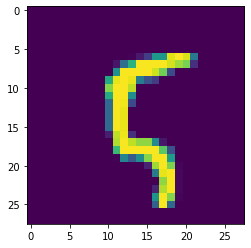

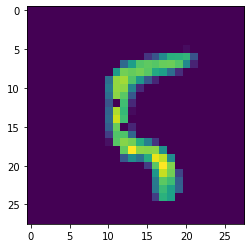

In [4]:
#model

class Encoder(nn.Module):
    # 28*28 -> hidden -> out
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0, 1)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0, 1)
        self.linear3 = nn.Linear(hidden_dim, latent_dim)
        
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.dropout1(self.activation(self.linear1(x)))
        x = self.dropout2(self.activation(self.linear2(x)))
        x = self.activation(self.linear3(x))
            
        return x
        
class Decoder(nn.Module):
    # encoder_out -> hidden -> 28*28
    def __init__(self, latent_dim, hidden_dim, out_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0, 1)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0, 1)
        self.linear3 = nn.Linear(hidden_dim, out_dim)
        
        self.activation = nn.ReLU()


    def forward(self, x):
        x = self.dropout1(self.activation(self.linear1(x)))
        x = self.dropout2(self.activation(self.linear2(x)))
        x = self.activation(self.linear3(x))
            
        return x

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x
    
def collate_fn(data):
    pics = []
    target = []
    for item in data:

        pics.append(numpy.array(item[0]))
        target.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)).float() / 255,
        'target': torch.from_numpy(numpy.array(target)),
    }

# model
model = AutoEncoder(28*28, 300, 64)
model.train()
model.to(device)

#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

#dataset
dataset = datasets.MNIST('/Users/DNS/Documents/Школа Data Scientist/Project/Task 11 MNIST Полносвязная и сверточная сети', download=False)

#loss
loss_func = nn.MSELoss()

#dataloder
for epoch in range(20):
    dataloader = DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    print(f'epoch: {epoch + 1}')
    for step, batch in enumerate(dataloader):
        data = batch['data'].to(device).view(batch['data'].size(0), -1)
        optim.zero_grad()
        predict = model(data)
        loss = loss_func(predict, data)
        loss.backward()
        optim.step()
        if (step % 100 == 0):
            print(loss)
    
test = dataset.data[100].view(1,-1).float() / 255
predict = model(test)

plt.imshow(test[0].view(28,28).detach().numpy())
plt.show()

plt.imshow(predict[0].view(28,28).detach().numpy())
plt.show()

# Автокодировщик на сверточной сети

In [5]:
class Encoder(nn.Module):
    # #conv2d -> maxpool2d -> conv2d -> maxpool2d -> conv2d
    def __init__(in_chan, hidden_chan):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chan, hidden_chan, kernal_size = 5, stride = 1, padding = 2) # 28*28
        self.pool1 = MaxPool2d(2, 2) # 14*14
        self.conv2 = nn.Conv2d(hidden_chan, hidden_chan, kernal_size = 3, stride = 1, padding = 2) # 14*14
        self.pool2 = MaxPool2d(2, 2) # 7*7
        self.conv3 = nn.Conv2d(hidden_chan, 1, kernal_size = 3, stride = 1, padding = 2)
                
        self.activation = nn.ReLU()
        
    def forward(self, x): # 7*7
        x = self.activation(self.pool1(self.conv1(x)))
        x = self.activation(self.pool2(self.conv2(x)))
        x = self.activation(self.conv3(x))
            
        return x
        
class Decoder(nn.Module):
    # conv2d -> upsampling2d -> conv2d -> upsampling2d -> conv2d
    def __init__(self, in_chan, hidden_chan):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_chan, kernal_size = 5, stride = 1, padding = 2) # 7*7
        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # > 14 x 14
        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)  # > 14 x 14
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2)  # 28 x 28
        self.conv3 = nn.Conv2d(hidden_ch, in_chan, kernel_size=3, stride=1, padding=1)
                
        self.activation = nn.ReLU()


    def forward(self, x): # 28*28
        x = self.activation(self.upsample1(self.conv1(x)))
        x = self.activation(self.upsample2(self.conv2(x)))
        x = self.activation(self.conv3(x))
            
        return x

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(input_dim, hidden_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x
    
def collate_fn(data):
    pics = []
    target = []
    for item in data:

        pics.append(numpy.array(item[0]))
        target.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)).float() / 255,
        'target': torch.from_numpy(numpy.array(target)),
    }

# model
model = AutoEncoder(1, 50)
model.train()
model.to(device)

#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

#dataset
dataset = datasets.MNIST('/Users/DNS/Documents/Школа Data Scientist/Project/Task 11 MNIST Полносвязная и сверточная сети', download=False)

#loss
loss_func = nn.MSELoss()

#dataloder
for epoch in range(2):
    dataloader = DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    print(f'epoch: {epoch + 1}')
    for step, batch in enumerate(dataloader):
        data = batch['data'].to(device).unsqueeze(1)
        optim.zero_grad()
        predict = model(data)
        loss = loss_func(predict, data)
        loss.backward()
        optim.step()
        if (step % 100 == 0):
            print(loss)
    
test = dataset.data[100].view(1,-1).float() / 255
predict = model(test)

plt.imshow(test[0].view(28,28).detach().numpy())
plt.show()

plt.imshow(predict[0].view(28,28).detach().numpy())
plt.show()

TypeError: __init__() takes 2 positional arguments but 3 were given